In [1]:
%matplotlib inline
import os,random
os.environ["KERAS_BACKEND"] = "theano"
#os.environ["THEANO_FLAGS"]  = "device=gpu%d,lib.cnmem=0"%(random.randint(0,3))
import numpy as np
import theano as th
import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers import Input,merge
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten,MaxoutDense
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import *
from keras.layers.wrappers import TimeDistributed
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, UpSampling2D
from keras.layers.recurrent import LSTM
from keras.regularizers import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.datasets import mnist
import matplotlib.pyplot as plt
import seaborn as sns
import cPickle, random, sys, keras
from keras.models import Model
from IPython import display

sys.path.append("../common")
from keras.utils import np_utils
from tqdm import tqdm

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5004)
Using Theano backend.
/usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

print np.min(X_train), np.max(X_train)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

0.0 1.0
('X_train shape:', (60000, 1, 28, 28))
(60000, 'train samples')
(10000, 'test samples')


In [3]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [4]:
shp = X_train.shape[1:]
dropout_rate = 0.25
opt = Adam(lr=1e-4)
dopt = Adam(lr=1e-3)

# Build Generative model ...
nch = 200
g_input = Input(shape=[100])
H = Dense(nch*14*14, init='glorot_normal')(g_input)
H = BatchNormalization(mode=2)(H)
H = Activation('relu')(H)
H = Reshape( [nch, 14, 14] )(H)
H = UpSampling2D(size=(2, 2))(H)
H = Convolution2D(nch/2, 3, 3, border_mode='same', init='glorot_uniform')(H)
H = BatchNormalization(mode=2)(H)
H = Activation('relu')(H)
H = Convolution2D(nch/4, 3, 3, border_mode='same', init='glorot_uniform')(H)
H = BatchNormalization(mode=2)(H)
H = Activation('relu')(H)
H = Convolution2D(1, 1, 1, border_mode='same', init='glorot_uniform')(H)
g_V = Activation('sigmoid')(H)
generator = Model(g_input,g_V)
generator.compile(loss='binary_crossentropy', optimizer=opt)
generator.summary()


# Build Discriminative model ...
d_input = Input(shape=shp)
H = Convolution2D(256, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(d_input)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Convolution2D(512, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Flatten()(H)
H = Dense(256)(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
d_V = Dense(2,activation='softmax')(H)
discriminator = Model(d_input,d_V)
discriminator.compile(loss='categorical_crossentropy', optimizer=dopt)
discriminator.summary()

# Freeze weights in the discriminator for stacked training
make_trainable(discriminator, False)

# Build stacked GAN model
gan_input = Input(shape=[100])
H = generator(gan_input)
gan_V = discriminator(H)
GAN = Model(gan_input, gan_V)
GAN.compile(loss='categorical_crossentropy', optimizer=opt)
GAN.summary()


(1, 28, 28)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 39200)         3959200     input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNormal(None, 39200)         78400       dense_1[0][0]                    
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 39200)         0           batchnormalization_1[0][0]       
_______________________________________________________________________________

In [5]:
def plot_loss(losses):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.figure(figsize=(10,8))
        plt.plot(losses["d"], label='discriminitive loss')
        plt.plot(losses["g"], label='generative loss')
        plt.legend()
        plt.show()

In [6]:
def plot_gen(n_ex=16,dim=(4,4), figsize=(10,10) ):
    noise = np.random.uniform(0,1,size=[n_ex,100])
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,0,:,:]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [7]:
ntrain = 10000
trainidx = random.sample(range(0,X_train.shape[0]), ntrain)
XT = X_train[trainidx,:,:,:]

# Pre-train the discriminator network ...
noise_gen = np.random.uniform(0,1,size=[XT.shape[0],100])
generated_images = generator.predict(noise_gen)
X = np.concatenate((XT, generated_images))
n = XT.shape[0]
y = np.zeros([2*n,2])
y[:n,1] = 1
y[n:,0] = 1

make_trainable(discriminator,True)
discriminator.fit(X,y, nb_epoch=1, batch_size=128)
y_hat = discriminator.predict(X)


Epoch 1/1
20000/20000 [==============================] - 9s - loss: 0.0405     


In [8]:
y_hat_idx = np.argmax(y_hat,axis=1)
y_idx = np.argmax(y,axis=1)
diff = y_idx-y_hat_idx
n_tot = y.shape[0]
n_rig = (diff==0).sum()
acc = n_rig*100.0/n_tot
print "Accuracy: %0.02f pct (%d of %d) right"%(acc, n_rig, n_tot)

Accuracy: 100.00 pct (20000 of 20000) right


In [9]:
# set up loss storage vector
losses = {"d":[], "g":[]}

In [10]:
def train_for_n(nb_epoch=5000, plt_frq=25,BATCH_SIZE=32):

    for e in tqdm(range(nb_epoch)):  
        
        # Make generative images
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=BATCH_SIZE),:,:,:]    
        noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        generated_images = generator.predict(noise_gen)
        
        # Train discriminator on generated images
        X = np.concatenate((image_batch, generated_images))
        y = np.zeros([2*BATCH_SIZE,2])
        y[0:BATCH_SIZE,1] = 1
        y[BATCH_SIZE:,0] = 1
        
        #make_trainable(discriminator,True)
        d_loss  = discriminator.train_on_batch(X,y)
        losses["d"].append(d_loss)
    
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        y2 = np.zeros([BATCH_SIZE,2])
        y2[:,1] = 1
        
        #make_trainable(discriminator,False)
        g_loss = GAN.train_on_batch(noise_tr, y2 )
        losses["g"].append(g_loss)
        
        # Updates plots
        if e%plt_frq==plt_frq-1:
            plot_loss(losses)
            plot_gen()
        

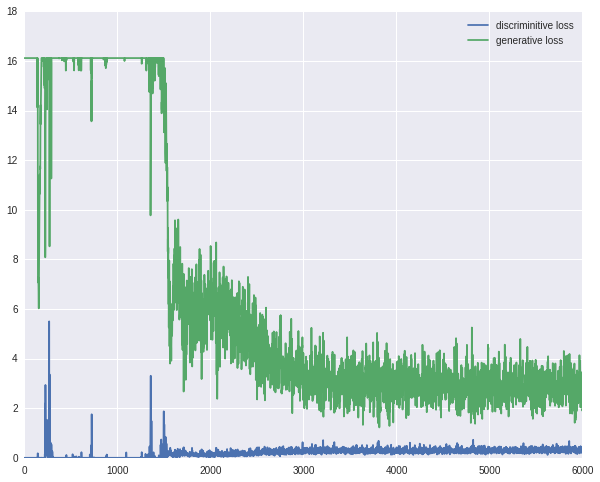

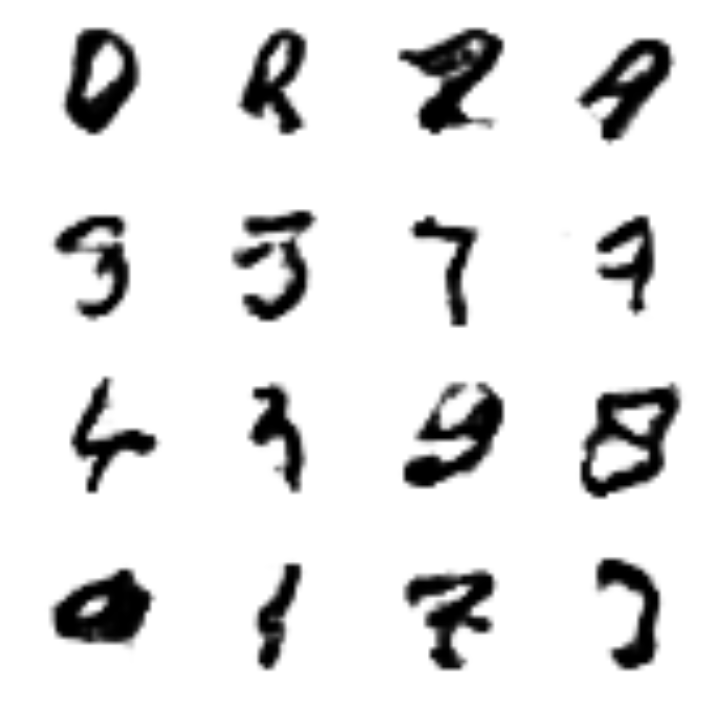

100%|██████████| 6000/6000 [32:40<00:00,  1.31it/s]


In [11]:
train_for_n(nb_epoch=6000, plt_frq=25,BATCH_SIZE=32)

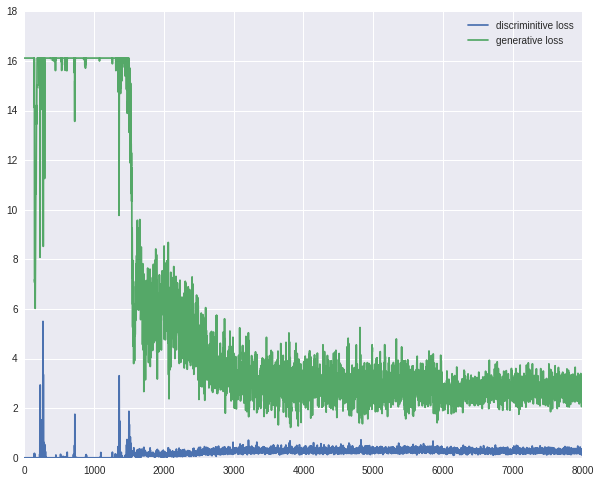

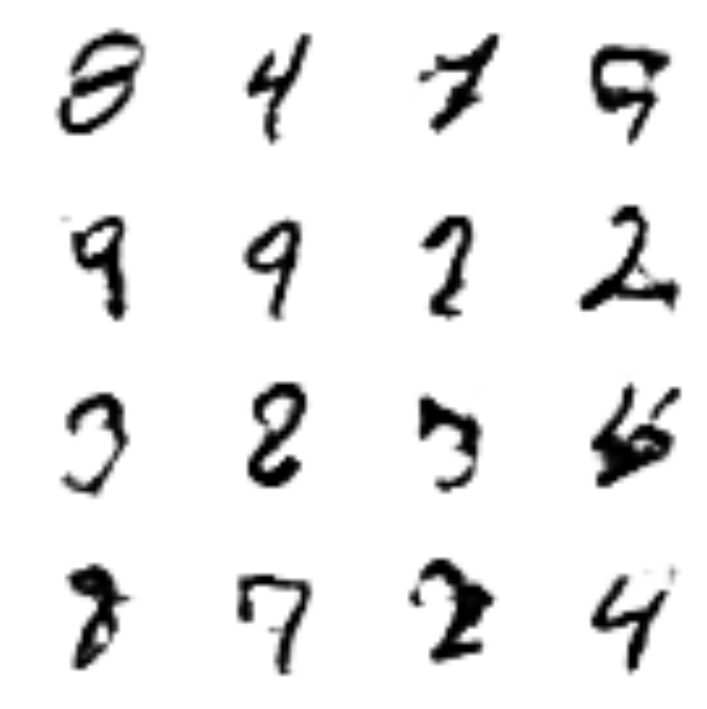

100%|██████████| 2000/2000 [10:47<00:00,  1.30it/s]


In [12]:
opt.lr.set_value(1e-5)
dopt.lr.set_value(1e-4)
train_for_n(nb_epoch=2000, plt_frq=25,BATCH_SIZE=32)

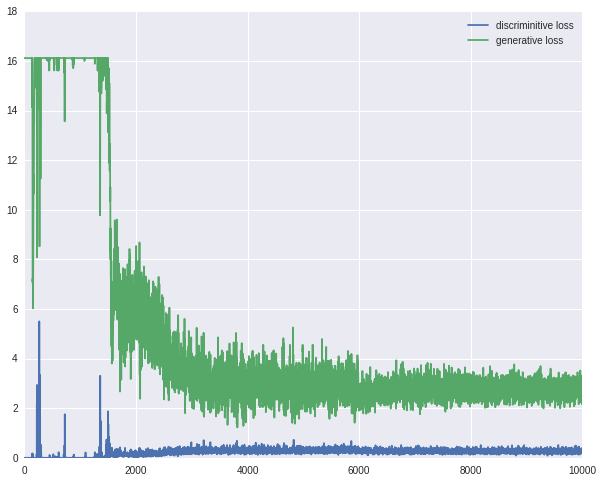

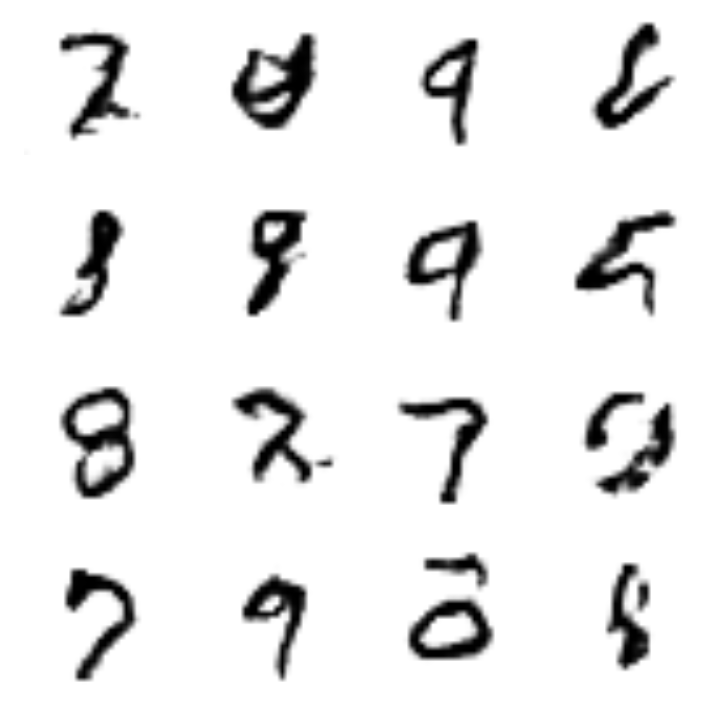

100%|██████████| 2000/2000 [10:48<00:00,  1.30it/s]


In [13]:
opt.lr.set_value(1e-6)
dopt.lr.set_value(1e-5)
train_for_n(nb_epoch=2000, plt_frq=25,BATCH_SIZE=32)

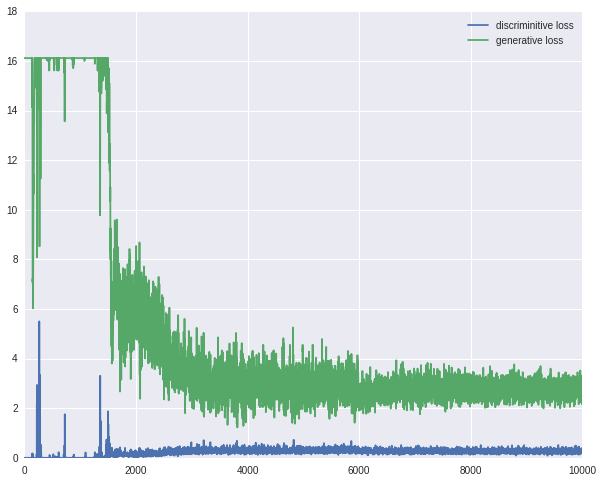

In [14]:
plot_loss(losses)

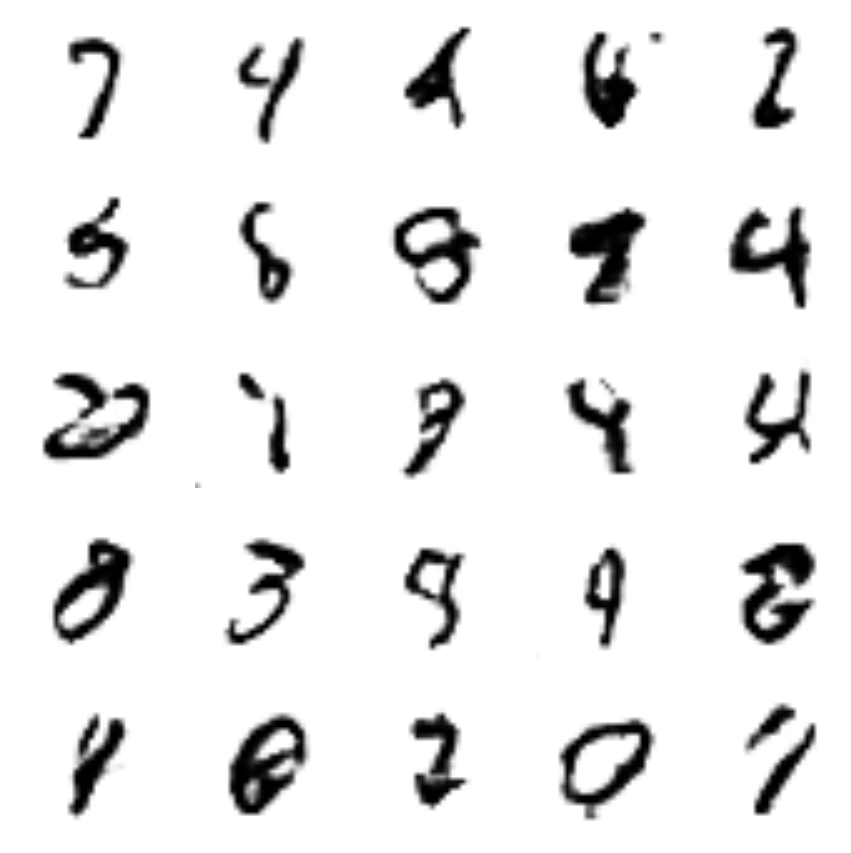

In [15]:
plot_gen(25,(5,5),(12,12))

In [16]:
def plot_real(n_ex=16,dim=(4,4), figsize=(10,10) ):
    
    idx = np.random.randint(0,X_train.shape[0],n_ex)
    generated_images = X_train[idx,:,:,:]

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,0,:,:]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()



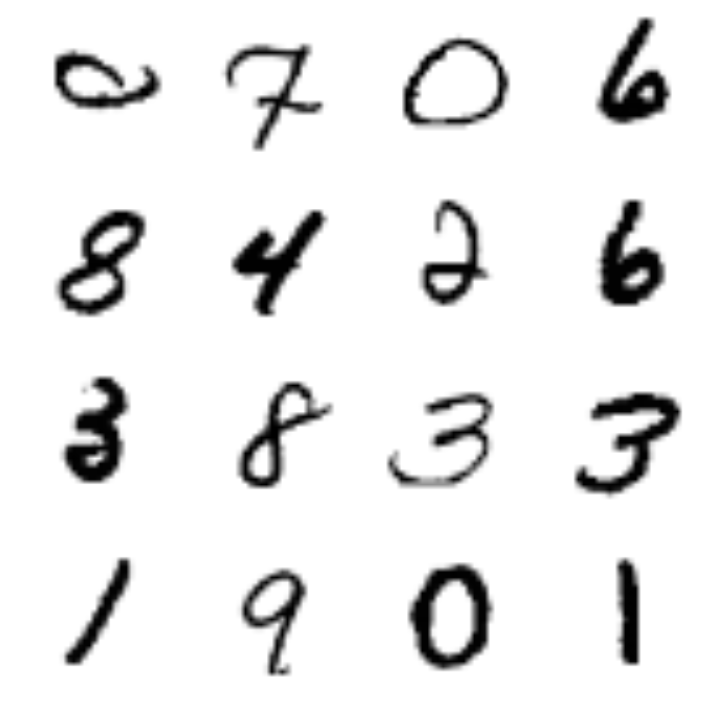

In [17]:
plot_real()